Topik   : Close Price Prediction

Metode  : Deep learning LSTM dan BiLSTM

Universitas Host: Institut Teknologi Bandung
Kelas: ITB-02

Kelompok 5

Nama Peserta:
1. Joshua Galilea
2. Adil Faruq Habibi
3. Ismar Apuandi


Link Web    : https://share.streamlit.io/afhabibieee/closing-price-prediction/main/app.py


# Install Required Library

In [ ]:
!pip install yfinance --upgrade --no-cache-dir #(For pip)

In [ ]:
!pip install --upgrade mplfinance

# Import Required Library

In [ ]:
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
from copy import deepcopy

# Data Preparation

In [ ]:
list_of_tickers = ['BBRI.JK', 'BBCA.JK', 'BBNI.JK', 'BMRI.JK']    # Beberapa list tickers yang mungkin bisa dilakukan transfer learning
start = '2003-11-10'
end = '2021-12-10'

In [ ]:
data = pdr.get_data_yahoo(
    tickers=list_of_tickers[0],
    start=start,
    end= end
)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-11-10,105.0,110.0,95.0,97.5,58.935944,5144140000
2003-11-11,97.5,100.0,95.0,100.0,60.447090,2938555000
2003-11-12,97.5,105.0,97.5,105.0,63.469452,2002915000
2003-11-13,105.0,105.0,102.5,105.0,63.469452,1190050000
2003-11-14,105.0,105.0,100.0,105.0,63.469452,1725265000
...,...,...,...,...,...,...
2021-12-03,4210.0,4220.0,4170.0,4170.0,4170.000000,93227100
2021-12-06,4200.0,4220.0,4110.0,4110.0,4110.000000,106610000
2021-12-07,4190.0,4230.0,4160.0,4230.0,4230.000000,182048000


In [ ]:
dates = data.index
dates

DatetimeIndex(['2003-11-10', '2003-11-11', '2003-11-12', '2003-11-13',
               '2003-11-14', '2003-11-17', '2003-11-18', '2003-11-19',
               '2003-11-20', '2003-11-21',
               ...
               '2021-11-26', '2021-11-29', '2021-11-30', '2021-12-01',
               '2021-12-02', '2021-12-03', '2021-12-06', '2021-12-07',
               '2021-12-08', '2021-12-09'],
              dtype='datetime64[ns]', name='Date', length=4499, freq=None)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4499 entries, 2003-11-10 to 2021-12-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4499 non-null   float64
 1   High       4499 non-null   float64
 2   Low        4499 non-null   float64
 3   Close      4499 non-null   float64
 4   Adj Close  4499 non-null   float64
 5   Volume     4499 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 246.0 KB


> **Handling missing value**

1. Metode yang dilakukan adalah menghapus query pada data yang terdapat missing value tersebut.

2. Teknik imputasi dirasa kurang tepat/kurang perlu untuk dilakukan. Karena jumlahnya yang sangat sedikit dan juga tidak relevan. Kecuali imputasi dilakukan dari beberapa query sebelum dan sesudah dengan interval yang tidak terlau lebar (tidak menggunakan semua query pada data).

In [ ]:
if 0 not in np.array(data.isna().sum()):
  data.dropna(inplace=True)

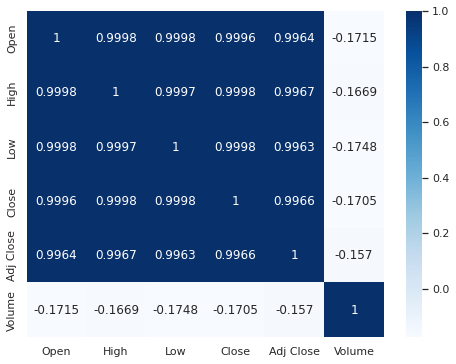

In [ ]:
# Cek Korelasi dengan Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap='Blues',fmt='.4g')
plt.show()

In [ ]:
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(data['Volume'], data['Close'])
p_value < 0.05

True

> Dari nilai p-value adalah kecil dari 0.05 menunjukkan bukti moderat bahwa korelasi antara variable Volume dan Close signifikan. 

>Tapi perlu dicek juga apakah terdapat hubungan sebab dan akibat antara dua variable tersebut

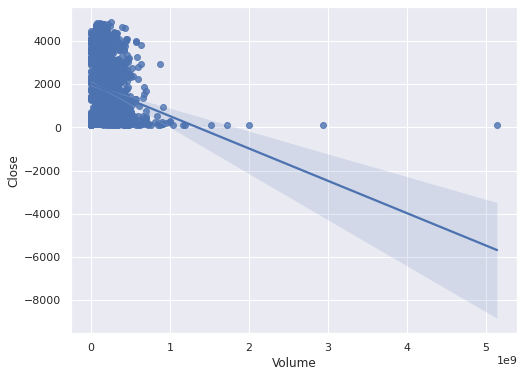

In [ ]:
# Cek causation antara Volume dan Close
plt.figure(figsize=(8,6))
sns.regplot(x='Volume', y='Close', data=data)
plt.show()

Dari grafik diatas bisa dilihat kalau kedua variable tidak memiliki hubungan sebab dan akibat. Maka kita hapus kolom 'Volume'

In [ ]:
# Drop variable Volume
data.drop('Volume', inplace=True, axis=1)

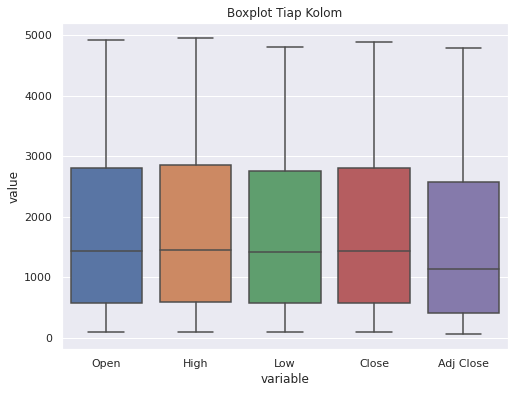

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Boxplot Tiap Kolom')
sns.boxplot(x="variable", y="value", data=pd.melt(data))
plt.show()

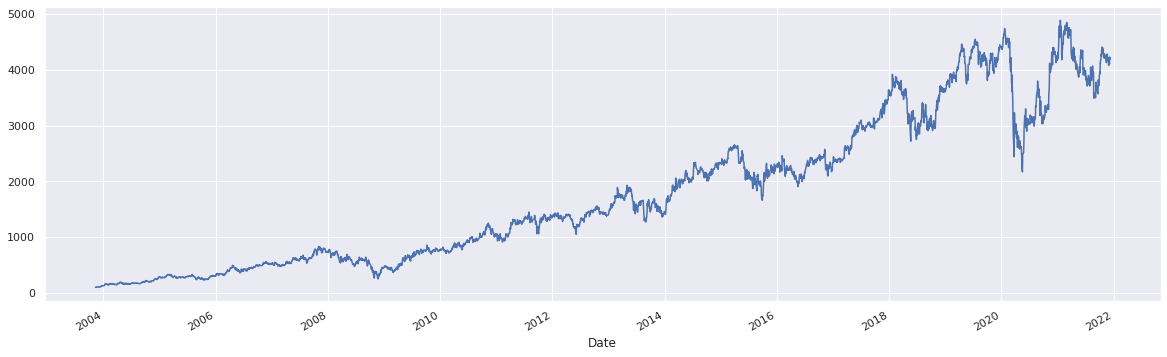

In [ ]:
plt.figure(figsize=(20,6))
data.Close.plot()
plt.show()

> Normalisasi Feature

Normalisasi feature menggunakan MinMaxScaler. Tidak menggunakan StandardScaler karena nilai negatif yang nantinya tidak begitu baik digunakan untuk pelatihan dengan metode deep learning, memungkinkan terjadinya vanishing gradient.

In [ ]:
# Normalisasi features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data)

In [ ]:
# Menampilkan 3 baris pertama
scaled[:3]

array([[0.00155521, 0.00206186, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00052165, 0.00031973],
       [0.        , 0.00103093, 0.00053135, 0.00156495, 0.00095919]])

In [ ]:
def series_to_supervised(data, column_target, n_in=1, n_out=1, dropnan=True):
  """ Fungsi ini dibuat untuk membentuk supervised (yang terdapat nilai target)
      
      parameter :

      - data, baik belum atau sudah di normalisasi
      - column_target, berupa index dari column yang akan diprediksikan
      - n_in atau time steps : jumlah langkah mundur (hari)/ time steps 
                               sebagai input untuk prediksi 
      - n_out atau future time steps : jumlah langkah maju (hari) yang
                                       nilainya diprediksi sebagai target

      return :

      dataframe dengan sejumlah n features (n: feature dikali jumlah timesteps) 
      dan target sejumlah hari / future time steps sesuai dengan column target.
  """
  
  if type(data) is list:
    n_vars = 1
  else:
    n_vars = data.shape[1]

  df = pd.DataFrame(data)
  cols, col_names = [], []

  # buat features
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    col_names += [('var%d(t-%d'%(j+1, i)) for j in range(n_vars)]
  
  # buat target
  for i in range(0, n_out):
    cols.append(df.iloc[:,column_target].shift(-i))
    if i == 0:
      col_names += ['var(t)']
    else:
      col_names += ['var(t+{})'.format(i)]
  
  df = pd.concat(cols, axis=1)
  df.columns = col_names

  if dropnan:
    df.dropna(inplace=True)
  
  return df

In [ ]:
pd.DataFrame(scaled).head()

,0,1,2,3,4
0,0.001555,0.002062,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000522,0.000320
2,0.000000,0.001031,0.000531,0.001565,0.000959
3,0.001555,0.001031,0.001594,0.001565,0.000959
4,0.001555,0.001031,0.001063,0.001565,0.000959


In [ ]:
# Config

timeSteps=10        # 10 hari terakhir sebagai input
futureTimeSteps=5   # prediksi 5 hari ke depan   
n_features = scaled.shape[1]
n_observe = timeSteps * n_features    # jumlah feature series to supervised
column_target = -2  # adalah column Close
column_features = [i for i in range(-n_features, 0, 1) if i != column_target]

In [ ]:
# bentuk menjadi dataframe series to supervised

data_supervised = series_to_supervised(scaled, column_target, timeSteps, futureTimeSteps)
data_supervised.head()

,var1(t-10,var2(t-10,var3(t-10,var4(t-10,var5(t-10,var1(t-9,var2(t-9,var3(t-9,var4(t-9,var5(t-9,var1(t-8,var2(t-8,var3(t-8,var4(t-8,var5(t-8,var1(t-7,var2(t-7,var3(t-7,var4(t-7,var5(t-7,var1(t-6,var2(t-6,var3(t-6,var4(t-6,var5(t-6,var1(t-5,var2(t-5,var3(t-5,var4(t-5,var5(t-5,var1(t-4,var2(t-4,var3(t-4,var4(t-4,var5(t-4,var1(t-3,var2(t-3,var3(t-3,var4(t-3,var5(t-3,var1(t-2,var2(t-2,var3(t-2,var4(t-2,var5(t-2,var1(t-1,var2(t-1,var3(t-1,var4(t-1,var5(t-1,var(t),var(t+1),var(t+2),var(t+3),var(t+4)
10,0.001555,0.002062,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000522,0.000320,0.000000,0.001031,0.000531,0.001565,0.000959,0.001555,0.001031,0.001594,0.001565,0.000959,0.001555,0.001031,0.001063,0.001565,0.000959,0.001037,0.000515,0.001063,0.000522,0.000320,0.000518,0.000000,0.000531,0.000000,0.000000,0.000000,0.000000,0.000531,0.000522,0.000320,0.000518,0.000515,0.001063,0.001043,0.000639,0.001037,0.001031,0.001594,0.001565,0.000959,0.001565,0.001565,0.001565,0.001565,0.001565
11,0.000000,0.000000,0.000000,0.000522,0.000320,0.000000,0.001031,0.000531,0.001565,0.000959,0.001555,0.001031,0.001594,0.001565,0.000959,0.001555,0.001031,0.001063,0.001565,0.000959,0.001037,0.000515,0.001063,0.000522,0.000320,0.000518,0.000000,0.000531,0.000000,0.000000,0.000000,0.000000,0.000531,0.000522,0.000320,0.000518,0.000515,0.001063,0.001043,0.000639,0.001037,0.001031,0.001594,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001565,0.001565,0.001565,0.001565,0.002087
12,0.000000,0.001031,0.000531,0.001565,0.000959,0.001555,0.001031,0.001594,0.001565,0.000959,0.001555,0.001031,0.001063,0.001565,0.000959,0.001037,0.000515,0.001063,0.000522,0.000320,0.000518,0.000000,0.000531,0.000000,0.000000,0.000000,0.000000,0.000531,0.000522,0.000320,0.000518,0.000515,0.001063,0.001043,0.000639,0.001037,0.001031,0.001594,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001565,0.001565,0.001565,0.002087,0.001565
13,0.001555,0.001031,0.001594,0.001565,0.000959,0.001555,0.001031,0.001063,0.001565,0.000959,0.001037,0.000515,0.001063,0.000522,0.000320,0.000518,0.000000,0.000531,0.000000,0.000000,0.000000,0.000000,0.000531,0.000522,0.000320,0.000518,0.000515,0.001063,0.001043,0.000639,0.001037,0.001031,0.001594,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001565,0.001565,0.002087,0.001565,0.001043
14,0.001555,0.001031,0.001063,0.001565,0.000959,0.001037,0.000515,0.001063,0.000522,0.000320,0.000518,0.000000,0.000531,0.000000,0.000000,0.000000,0.000000,0.000531,0.000522,0.000320,0.000518,0.000515,0.001063,0.001043,0.000639,0.001037,0.001031,0.001594,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001555,0.001031,0.002125,0.001565,0.000959,0.001565,0.002087,0.001565,0.001043,0.001565


In [ ]:
# bagi data feature dan target

X = data_supervised.values[:, :n_observe]
y = data_supervised.values[:, n_observe:]

In [ ]:
# bagi data testing untuk satu bulan : 20 hari

test_size = 20
X_train, y_train = X[:-test_size], y[:-test_size]
X_test, y_test = X[-test_size:], y[-test_size:]

In [ ]:
# Siapkan data untuk dilatih dan divalidasi (jumlah data validasi untuk 1 tahun)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.0847, 
                                                  shuffle=False)

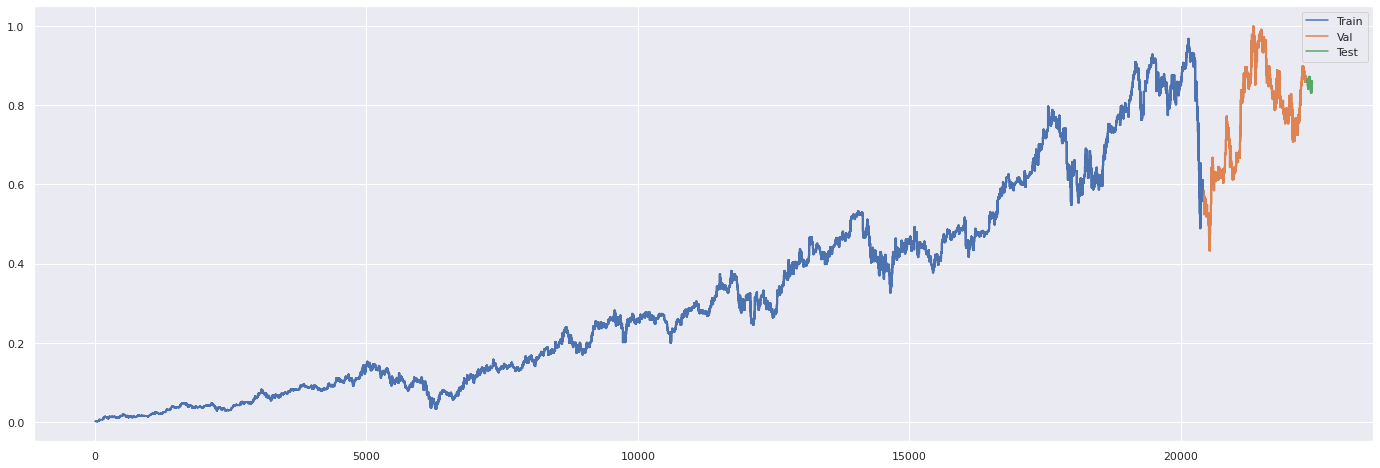

In [ ]:
plt.figure(figsize=(24, 8))
plt.plot(y_train.reshape(-1,))
plt.plot([None for i in y_train.reshape(-1,)] + [j for j in y_val.reshape(-1,)])
plt.plot([None for i in y_train.reshape(-1,)] + [None for j in y_val.reshape(-1,)] + [k for k in y_test.reshape(-1,)])
plt.legend(('Train', 'Val', 'Test'), loc='best')
plt.show()

In [ ]:
# reshape input untuk lstm model

X_train = X_train.reshape(X_train.shape[0], timeSteps, n_features)
X_val = X_val.reshape(X_val.shape[0], timeSteps, n_features)
X_test = X_test.reshape(X_test.shape[0], timeSteps, n_features)

In [ ]:
# jumlah rows dari data training, jumlah timestamp, jumlah feature
print(X_train.shape, X_val.shape, X_test.shape)

(4086, 10, 5) (379, 10, 5) (20, 10, 5)


# LSTM Model 1

In [ ]:
# buat model
def build_model_lstm():
    model = Sequential([
                        LSTM(150, input_shape=(timeSteps, n_features), return_sequences=True),
                        LSTM(80, 'tanh', dropout=0.5),
                        Dense(20, 'tanh'),
                        Dropout(0.05),
                        Dense(futureTimeSteps)
    ])
    
    model.compile(loss='mse', optimizer=Adam(), metrics='mae')
    return model

In [ ]:
model_lstm = build_model_lstm()
model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 10, 150)           93600     
                                                                 
 lstm_17 (LSTM)              (None, 80)                73920     
                                                                 
 dense_14 (Dense)            (None, 20)                1620      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_15 (Dense)            (None, 5)                 105       
                                                                 
Total params: 169,245
Trainable params: 169,245
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               mode='min')

In [ ]:
# Atur learning rate schedule
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(1e-4, 0.75, 2)

In [ ]:
history_lstm_model = model_lstm.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=100, shuffle=False,
    callbacks=[early_stopping, lr_sched]
)

Epoch 1/100
128/128 [==============================] - 8s 38ms/step - loss: 0.0035 - mae: 0.0390 - val_loss: 0.0090 - val_mae: 0.0803 - lr: 1.0000e-04
Epoch 2/100
128/128 [==============================] - 4s 28ms/step - loss: 0.0035 - mae: 0.0415 - val_loss: 0.0054 - val_mae: 0.0615 - lr: 1.0000e-04
Epoch 3/100
128/128 [==============================] - 4s 29ms/step - loss: 0.0028 - mae: 0.0340 - val_loss: 0.0043 - val_mae: 0.0551 - lr: 7.5000e-05
Epoch 4/100
128/128 [==============================] - 4s 31ms/step - loss: 0.0026 - mae: 0.0305 - val_loss: 0.0039 - val_mae: 0.0528 - lr: 7.5000e-05
Epoch 5/100
128/128 [==============================] - 4s 30ms/step - loss: 0.0026 - mae: 0.0303 - val_loss: 0.0040 - val_mae: 0.0535 - lr: 5.6250e-05
Epoch 6/100
128/128 [==============================] - 4s 28ms/step - loss: 0.0024 - mae: 0.0297 - val_loss: 0.0038 - val_mae: 0.0519 - lr: 5.6250e-05
Epoch 7/100
128/128 [==============================] - 4s 29ms/step - loss: 0.0025 - mae: 0.03

In [ ]:
print('Eval train :', model_lstm.evaluate(X_train, y_train, verbose=0))
print('Eval val   :', model_lstm.evaluate(X_val, y_val, verbose=0))
print('Eval test  :', model_lstm.evaluate(X_test, y_test, verbose=0))

Eval train : [0.000442942458903417, 0.013440634123980999]
Eval val   : [0.0022655667271465063, 0.037646740674972534]
Eval test  : [0.00012803950812667608, 0.00923539511859417]


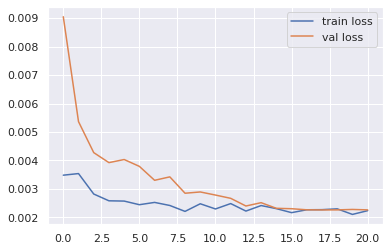

In [ ]:
plt.plot(history_lstm_model.history['loss'], label='train loss')
plt.plot(history_lstm_model.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [ ]:
model_lstm.save('model_lstm.h5')

In [ ]:
# Hitung r2 score
y_val_pred_lstm = model_lstm.predict(X_val)

r2 = r2_score(y_val, y_val_pred_lstm)
rmse = sqrt(mean_squared_error(y_val, y_val_pred_lstm))
print('Test r2 score: {}'.format(r2))
print('Test rmse: {}'.format(rmse))

Test r2 score: 0.8609902135018727
Test rmse: 0.04759797099391778


# Model LSTM 2

In [ ]:
# buat model
def build_model_lstm2():
    model = Sequential([
                        LSTM(64, input_shape=(timeSteps, n_features), return_sequences=True),
                        LSTM(32, dropout=0.3),
                        Dense(futureTimeSteps)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=3e-5), metrics='mae')
    return model

In [ ]:
model_lstm2 = build_model_lstm2()
model_lstm2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 10, 64)            17920     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_16 (Dense)            (None, 5)                 165       
                                                                 
Total params: 30,501
Trainable params: 30,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               mode='min')

In [ ]:
history_lstm_model2 = model_lstm2.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=100, shuffle=False,
    callbacks=[early_stopping]
)

Epoch 1/100
128/128 [==============================] - 7s 23ms/step - loss: 0.0748 - mae: 0.2169 - val_loss: 0.2032 - val_mae: 0.4241
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 0.0276 - mae: 0.1183 - val_loss: 0.0758 - val_mae: 0.2478
Epoch 3/100
128/128 [==============================] - 2s 14ms/step - loss: 0.0082 - mae: 0.0651 - val_loss: 0.0207 - val_mae: 0.1223
Epoch 4/100
128/128 [==============================] - 2s 15ms/step - loss: 0.0042 - mae: 0.0520 - val_loss: 0.0076 - val_mae: 0.0703
Epoch 5/100
128/128 [==============================] - 2s 14ms/step - loss: 0.0036 - mae: 0.0495 - val_loss: 0.0049 - val_mae: 0.0554
Epoch 6/100
128/128 [==============================] - 2s 15ms/step - loss: 0.0029 - mae: 0.0441 - val_loss: 0.0038 - val_mae: 0.0490
Epoch 7/100
128/128 [==============================] - 2s 13ms/step - loss: 0.0024 - mae: 0.0392 - val_loss: 0.0032 - val_mae: 0.0453
Epoch 8/100
128/128 [==============================] - 2s 16ms

In [ ]:
print('Eval train :', model_lstm2.evaluate(X_train, y_train, verbose=0))
print('Eval val   :', model_lstm2.evaluate(X_val, y_val, verbose=0))
print('Eval test  :', model_lstm2.evaluate(X_test, y_test, verbose=0))

Eval train : [0.000517454871442169, 0.014771152287721634]
Eval val   : [0.002420461270958185, 0.0402282252907753]
Eval test  : [0.0003905397898051888, 0.016723113134503365]


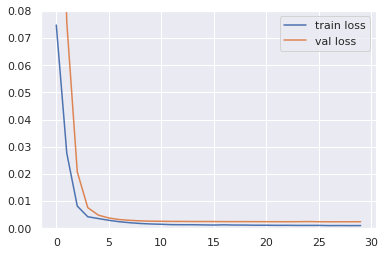

In [ ]:
plt.plot(history_lstm_model2.history['loss'], label='train loss')
plt.plot(history_lstm_model2.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.ylim(0,0.08)
plt.show()

In [ ]:
model_lstm2.save('model_lstm2.h5')

In [ ]:
# hitung r2 score
y_val_pred_lstm2 = model_lstm2.predict(X_val)

r2 = r2_score(y_val, y_val_pred_lstm2)
rmse = sqrt(mean_squared_error(y_val, y_val_pred_lstm2))
print('Test r2 score: {}'.format(r2))
print('Test rmse: {}'.format(rmse))

Test r2 score: 0.8515791675076733
Test rmse: 0.04919818411346731


Kedua model LSTM diatas memiliki skor r2 yang hampir sama, tapi secara komputasi model yang pertama lebih konsumtif (waktu dan memori)

# Birdirectional LSTM Model

In [ ]:
def build_model_bilstm():
  bimodel = Sequential([
                        Bidirectional(LSTM(175, return_sequences=True), 
                                      input_shape=(timeSteps, n_features)),
                        Dense(50, activation='tanh'),
                        Bidirectional(LSTM(125)),
                        Dense(20, activation='tanh'),
                        Dense(20, activation='tanh'),
                        Dropout(0.05),
                        Dense(units=futureTimeSteps)
  ])
  bimodel.compile(optimizer='adam', loss='mse', metrics='mae')
  return bimodel

In [ ]:
model_bilstm = build_model_bilstm()
model_bilstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 10, 350)          253400    
 l)                                                              
                                                                 
 dense_17 (Dense)            (None, 10, 50)            17550     
                                                                 
 bidirectional_1 (Bidirectio  (None, 250)              176000    
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 20)                5020      
                                                                 
 dense_19 (Dense)            (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)              

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               mode='min')

In [ ]:
history_bilstm = model_bilstm.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=20, batch_size=32, shuffle=False,
    callbacks=[lr_sched]
)

Epoch 1/20
128/128 [==============================] - 18s 82ms/step - loss: 0.0066 - mae: 0.0517 - val_loss: 0.0136 - val_mae: 0.0936 - lr: 1.0000e-04
Epoch 2/20
128/128 [==============================] - 8s 65ms/step - loss: 0.0075 - mae: 0.0578 - val_loss: 0.0114 - val_mae: 0.0859 - lr: 1.0000e-04
Epoch 3/20
128/128 [==============================] - 9s 69ms/step - loss: 0.0049 - mae: 0.0443 - val_loss: 0.0103 - val_mae: 0.0831 - lr: 7.5000e-05
Epoch 4/20
128/128 [==============================] - 9s 67ms/step - loss: 0.0047 - mae: 0.0435 - val_loss: 0.0074 - val_mae: 0.0704 - lr: 7.5000e-05
Epoch 5/20
128/128 [==============================] - 9s 68ms/step - loss: 0.0042 - mae: 0.0413 - val_loss: 0.0068 - val_mae: 0.0676 - lr: 5.6250e-05
Epoch 6/20
128/128 [==============================] - 9s 68ms/step - loss: 0.0038 - mae: 0.0381 - val_loss: 0.0052 - val_mae: 0.0598 - lr: 5.6250e-05
Epoch 7/20
128/128 [==============================] - 9s 68ms/step - loss: 0.0035 - mae: 0.0360 - v

In [ ]:
print('Eval train :', model_bilstm.evaluate(X_train, y_train, verbose=0))
print('Eval val   :', model_bilstm.evaluate(X_val, y_val, verbose=0))
print('Eval test  :', model_bilstm.evaluate(X_test, y_test, verbose=0))

Eval train : [0.0006708900327794254, 0.018757684156298637]
Eval val   : [0.002998939249664545, 0.042689356952905655]
Eval test  : [0.0009287301218137145, 0.02639828249812126]


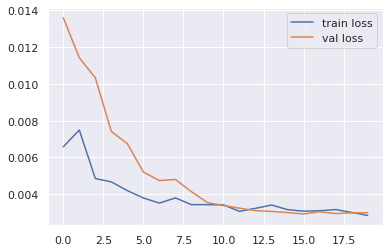

In [ ]:
plt.plot(history_bilstm.history['loss'], label='train loss')
plt.plot(history_bilstm.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
model_bilstm.save('model_bilstm.h5')

In [ ]:
# calculate r2 score
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

y_val_pred_bilstm = model_bilstm.predict(X_val)

r2 = r2_score(y_val, y_val_pred_bilstm)
rmse = sqrt(mean_squared_error(y_val, y_val_pred_bilstm))
print('Test r2 score: {}'.format(r2))
print('Test rmse: {}'.format(rmse))

Test r2 score: 0.8158705184732516
Test rmse: 0.05476257236930408


# Evaluasi Lanjutan

In [ ]:
y_test

array([[0.86645801, 0.86645801, 0.86645801, 0.86019823, 0.84767866],
       [0.86645801, 0.86645801, 0.86019823, 0.84767866, 0.84141888],
       [0.86645801, 0.86019823, 0.84767866, 0.84141888, 0.85602504],
       [0.86019823, 0.84767866, 0.84141888, 0.85602504, 0.85185185],
       [0.84767866, 0.84141888, 0.85602504, 0.85185185, 0.87271779],
       [0.84141888, 0.85602504, 0.85185185, 0.87271779, 0.87271779],
       [0.85602504, 0.85185185, 0.87271779, 0.87271779, 0.85811163],
       [0.85185185, 0.87271779, 0.87271779, 0.85811163, 0.85811163],
       [0.87271779, 0.87271779, 0.85811163, 0.85811163, 0.86019823],
       [0.87271779, 0.85811163, 0.85811163, 0.86019823, 0.84767866],
       [0.85811163, 0.85811163, 0.86019823, 0.84767866, 0.84976526],
       [0.85811163, 0.86019823, 0.84767866, 0.84976526, 0.83307251],
       [0.86019823, 0.84767866, 0.84976526, 0.83307251, 0.83098592],
       [0.84767866, 0.84976526, 0.83307251, 0.83098592, 0.85602504],
       [0.84976526, 0.83307251, 0.

In [ ]:
# prediksi dari data test
y_pred_lstm = model_lstm.predict(X_test)     # LSTM 1
y_pred_lstm2 = model_lstm2.predict(X_test)    # LSTM 2
y_pred_bilstm = model_bilstm.predict(X_test)   # BiLSTM

In [ ]:
# Visualisasi nilai prediksi dengan aktual

def perbandingan_prediksi(data, y_test, y_pred):
  # invers dari prediksi scaled
  y_pred_inv = scaler.inverse_transform(y_pred)

  # invers dari origin y scaled
  y_test_inv = scaler.inverse_transform(y_test)

  df = deepcopy(data)
  df['Dates'] = df.index

  for i in range(len(y_test_inv)):
      Prediction=y_pred_inv[i]
      Original=y_test_inv[i]

      # Visualising the results
      plt.plot(Prediction, color = 'blue', label = 'Predicted Close')
      plt.plot(Original, color = 'lightblue', label = 'Original Close')
  
      plt.title(' Akurasi Prediksi : '+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'% ')
      plt.xlabel('Date')

      startDateIndex=(futureTimeSteps*len(y_test_inv))-futureTimeSteps*(i+1)
      endDateIndex=(futureTimeSteps*len(y_test_inv))-futureTimeSteps*(i+1) + futureTimeSteps
      TotalRows=df.shape[0]
  
      plt.xticks(range(futureTimeSteps), df.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Dates'])
      plt.ylabel('Close Price')
  
      plt.legend()
      fig=plt.gcf()
      fig.set_figwidth(20)
      fig.set_figheight(3)
      plt.show()

---

### Visualisasi perbandingan dari model pertama (LSTM 1)

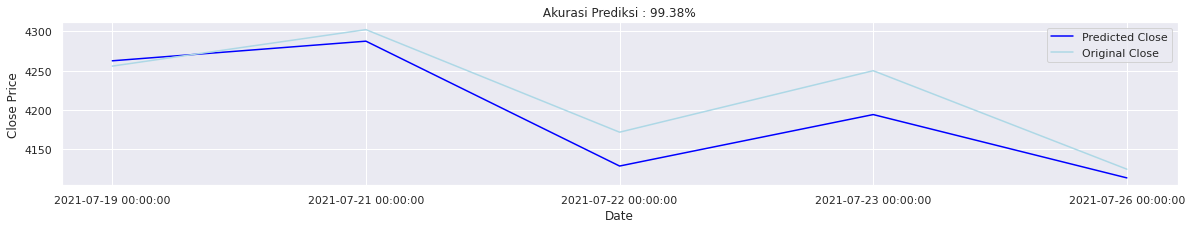

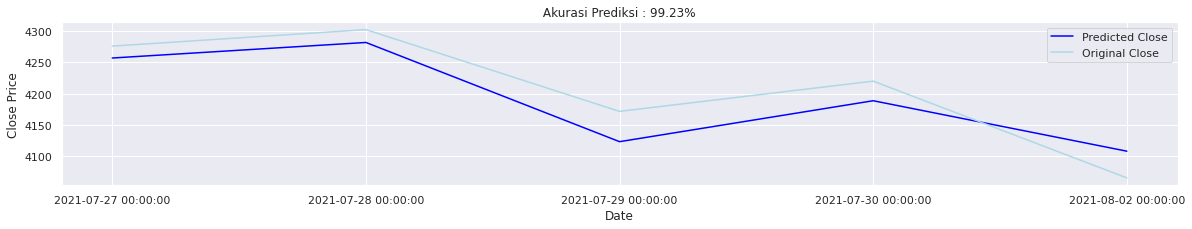

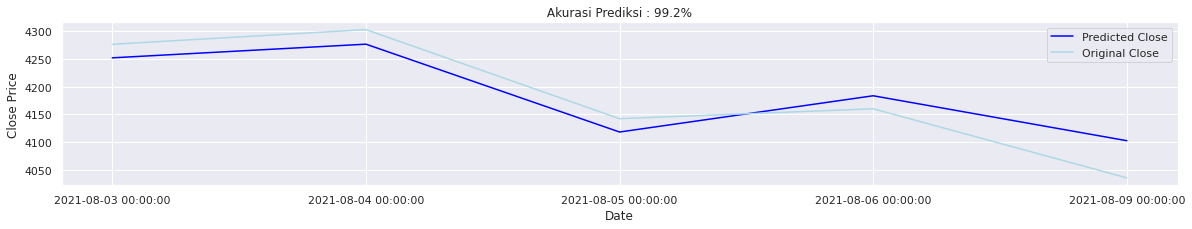

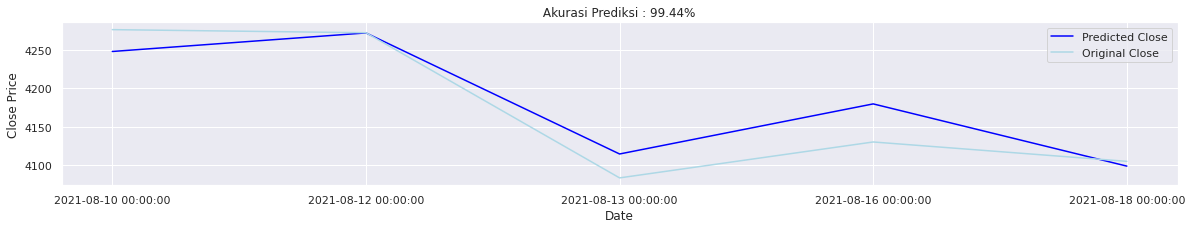

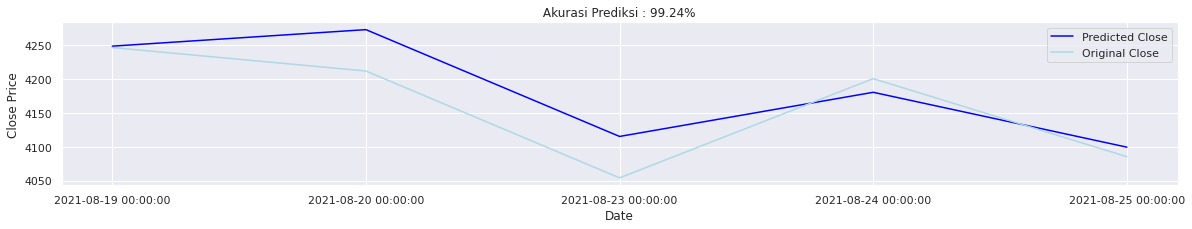

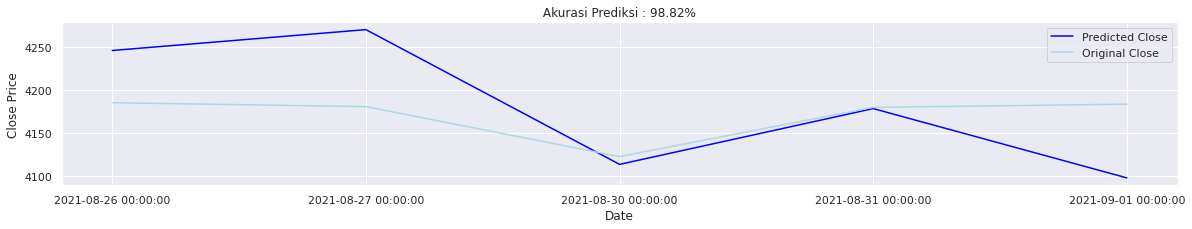

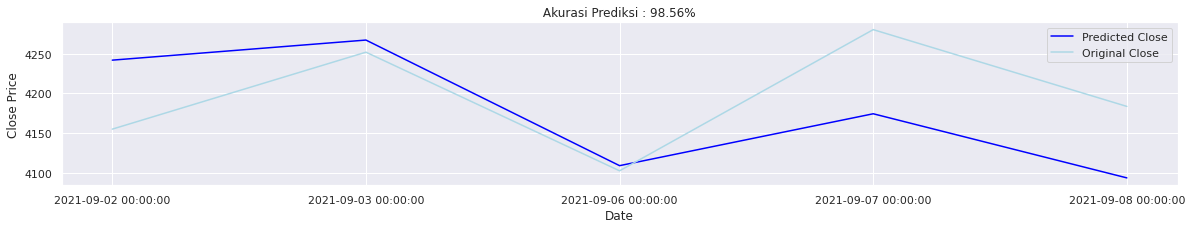

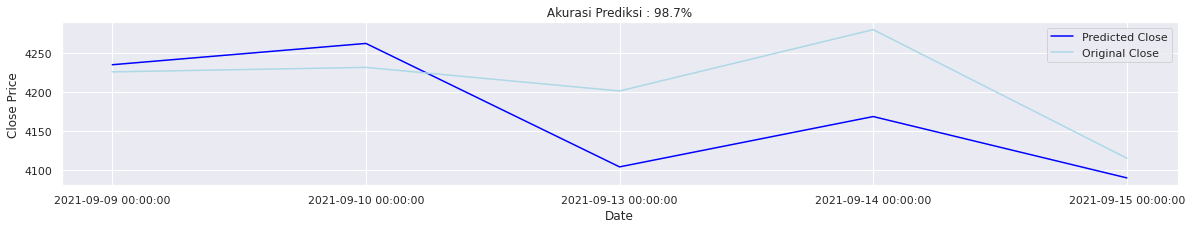

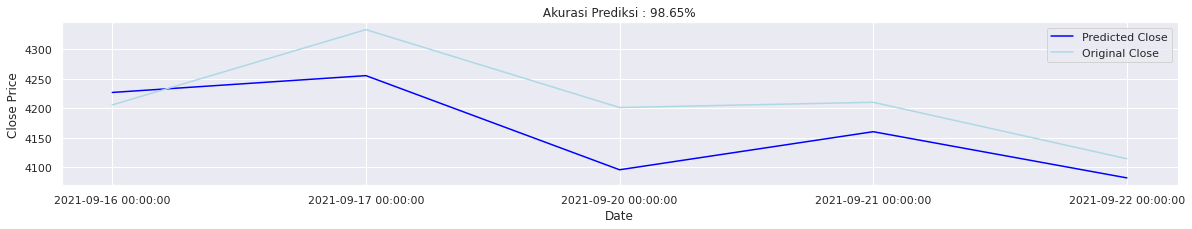

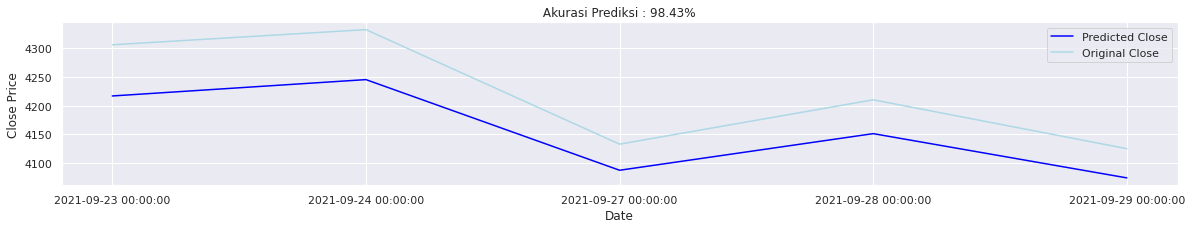

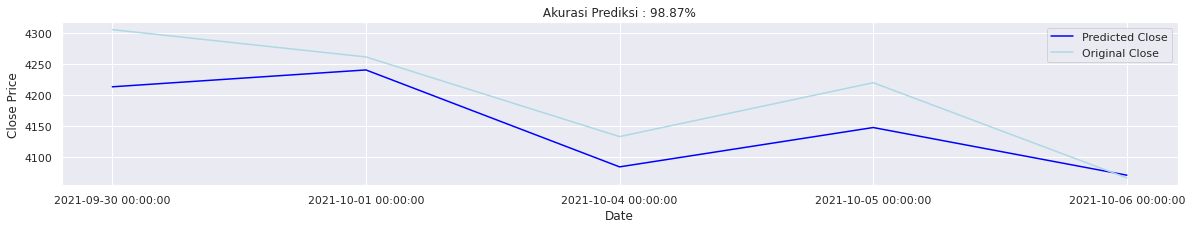

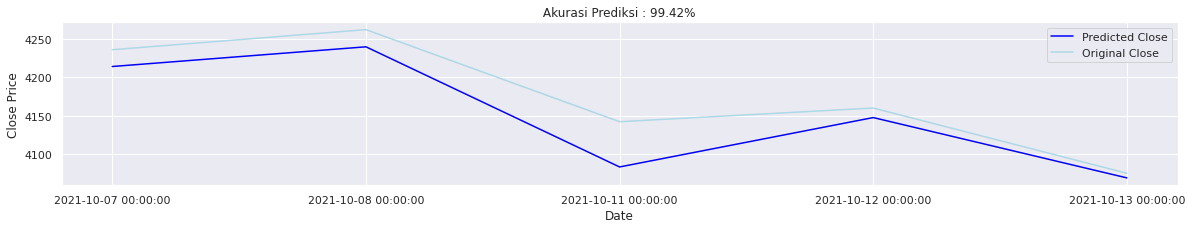

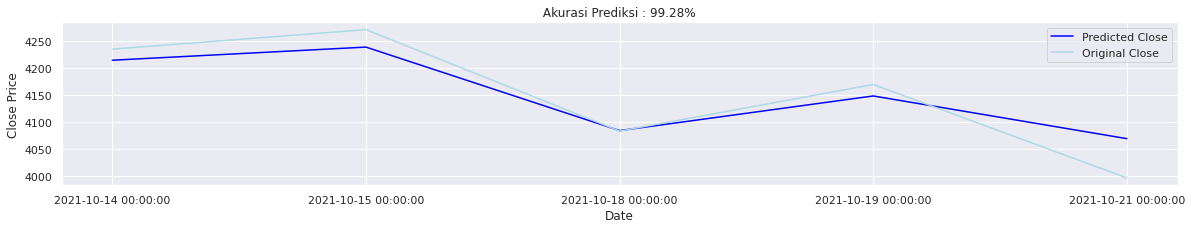

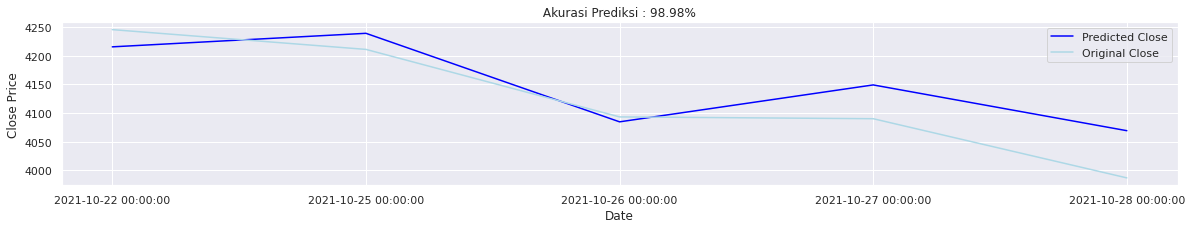

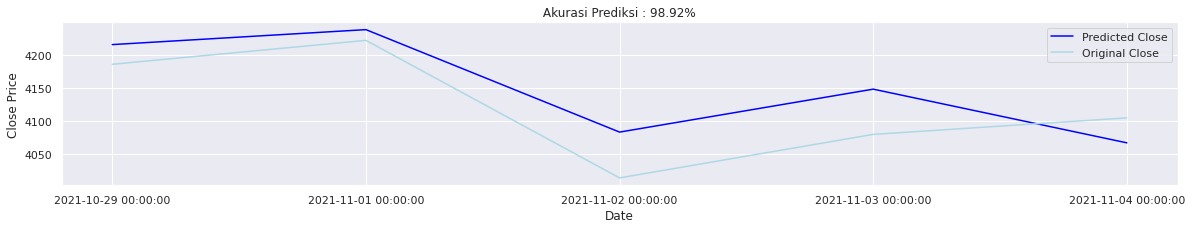

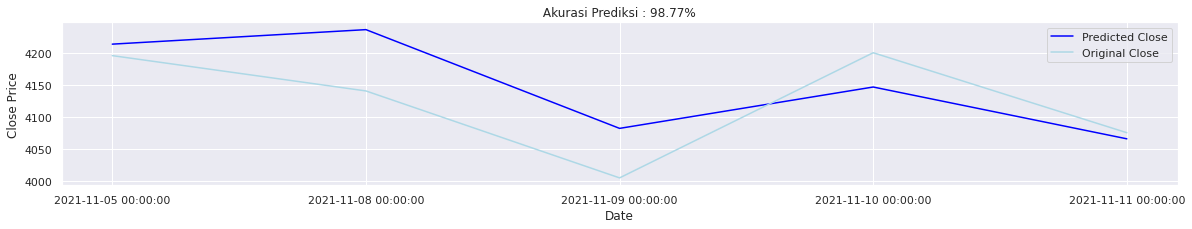

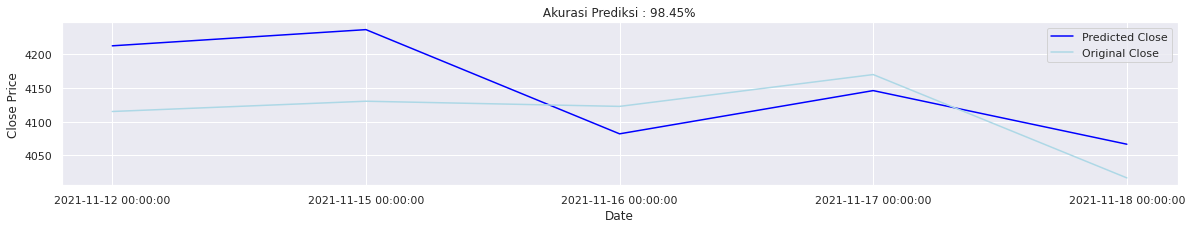

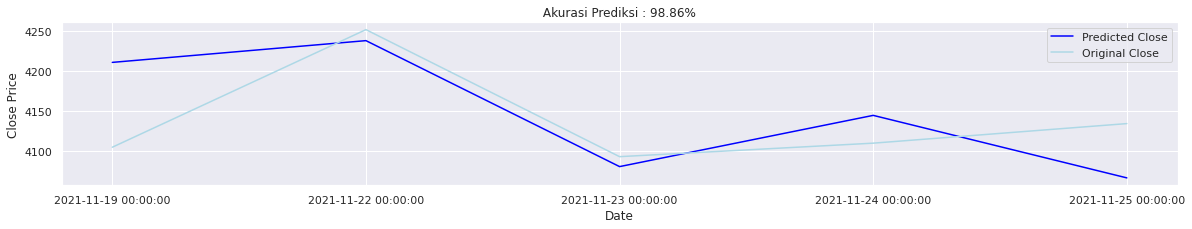

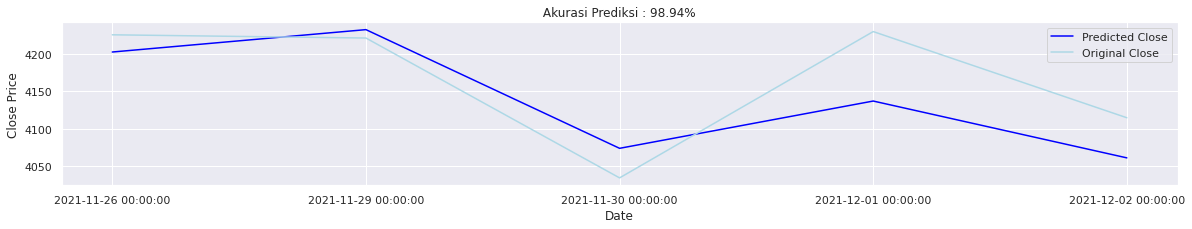

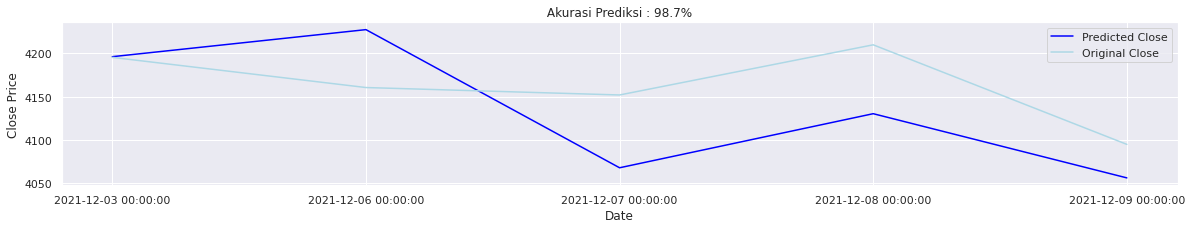

In [ ]:
perbandingan_prediksi(data, y_test, y_pred_lstm)

---

### Visualisasi perbandingan model kedua (LSTM 2)

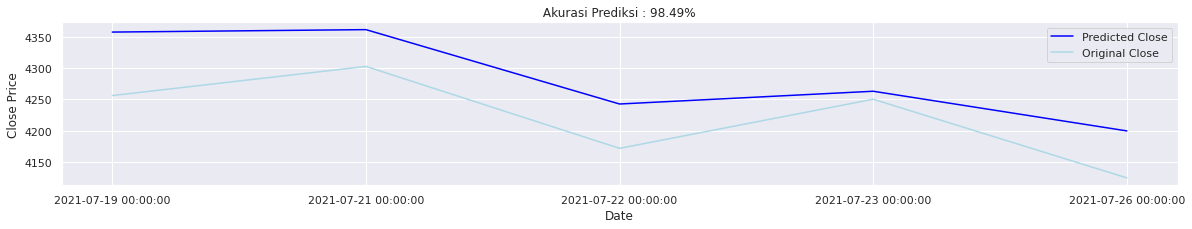

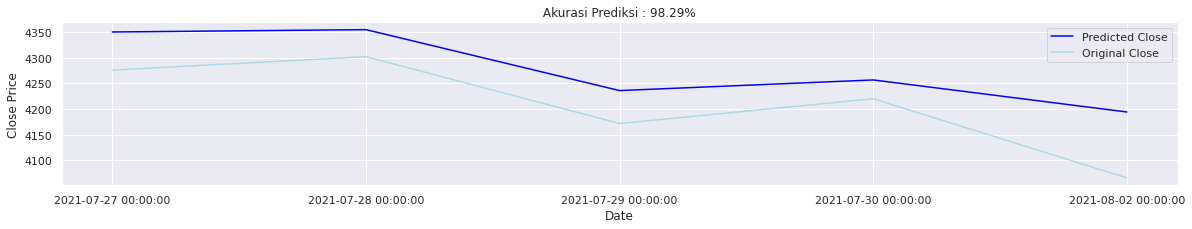

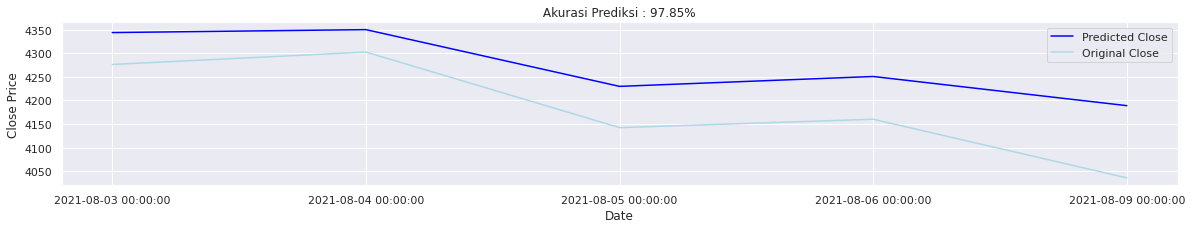

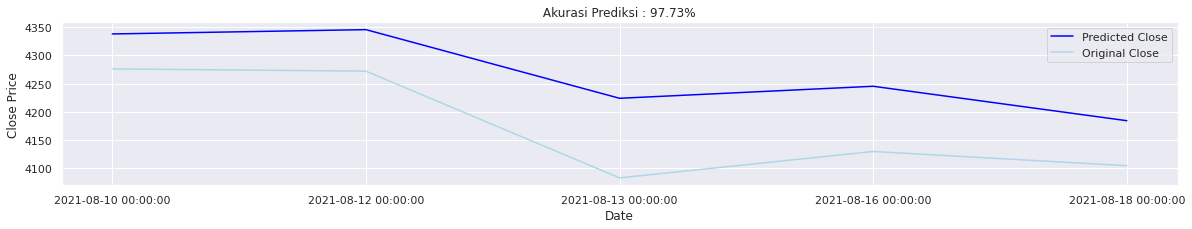

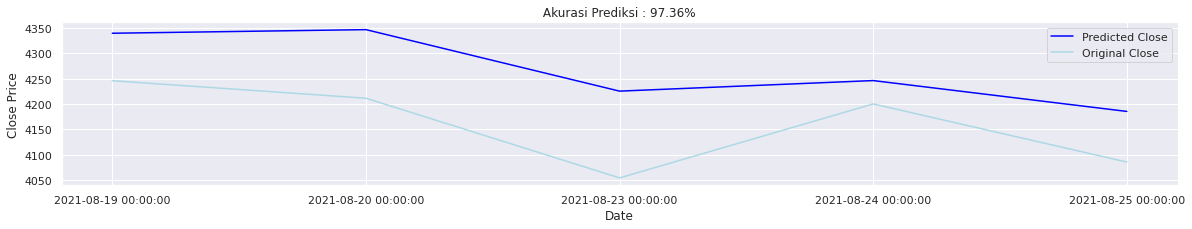

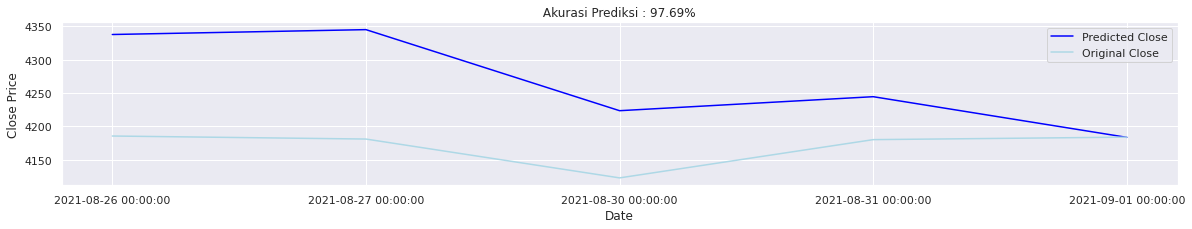

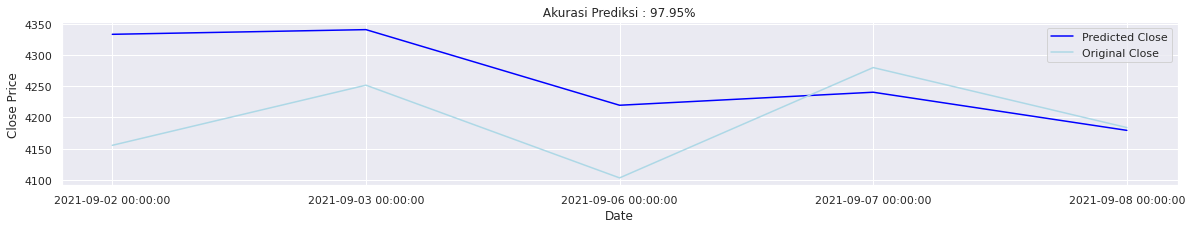

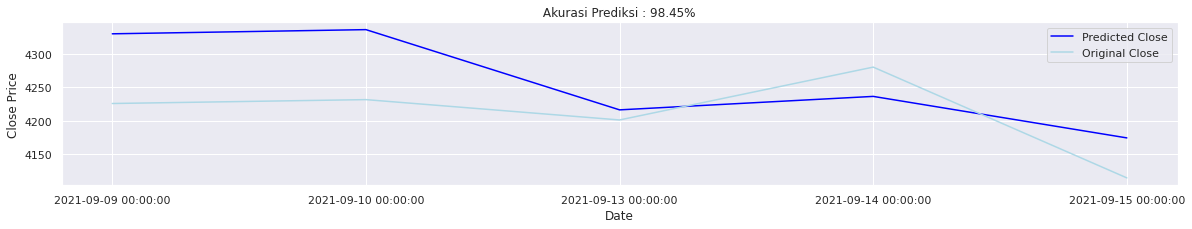

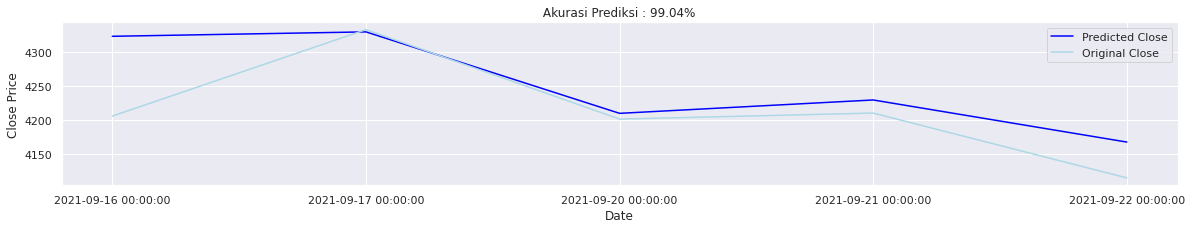

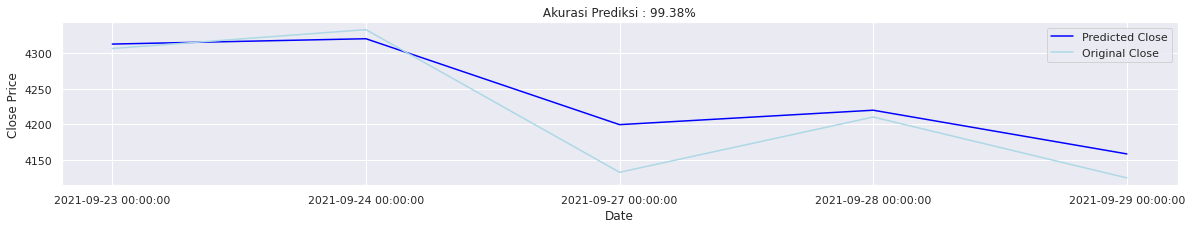

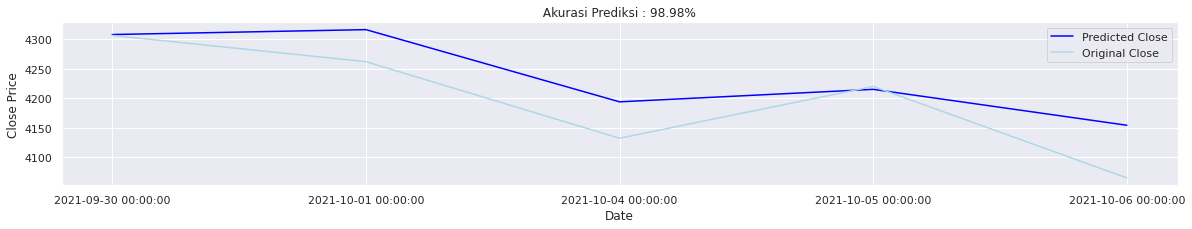

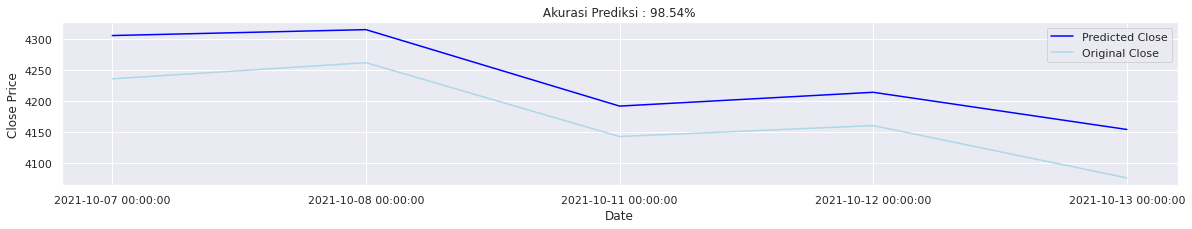

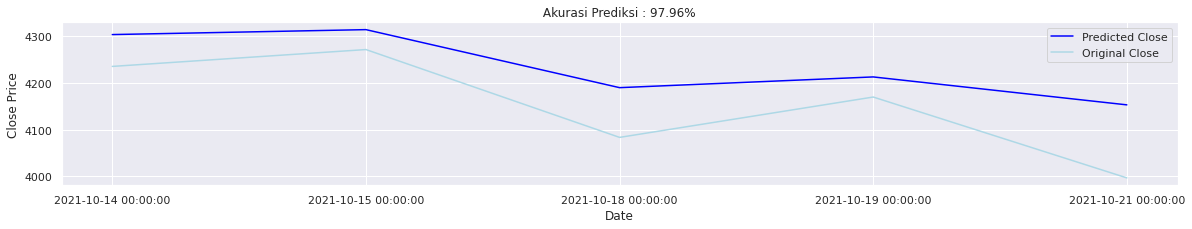

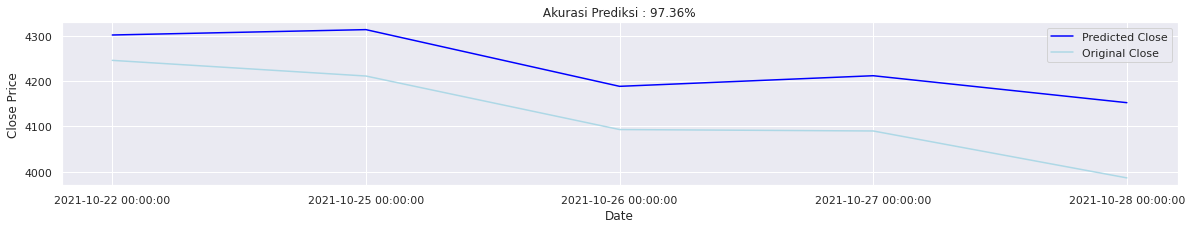

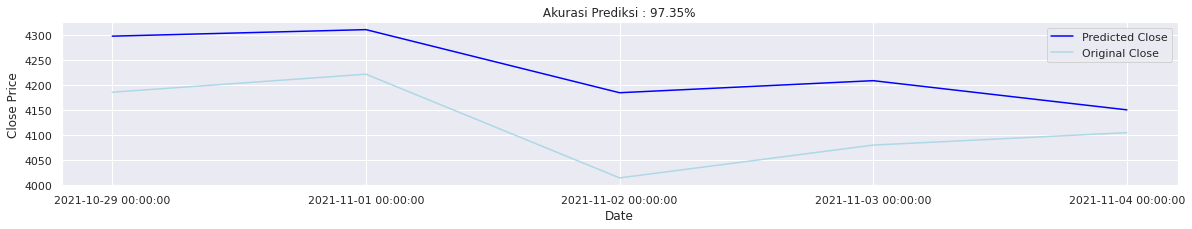

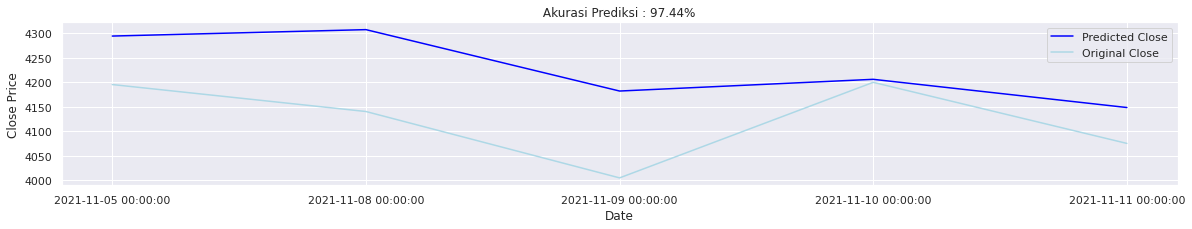

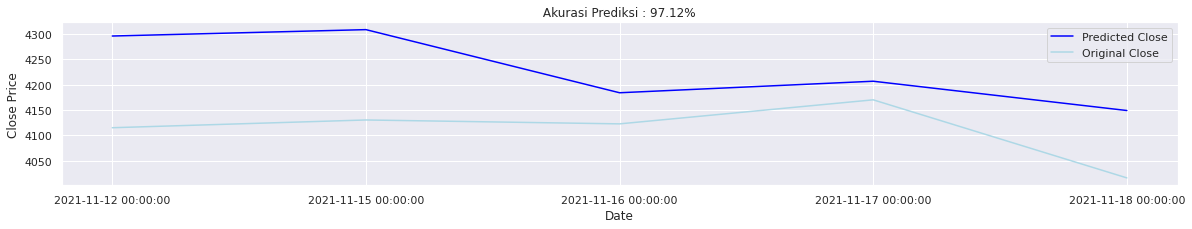

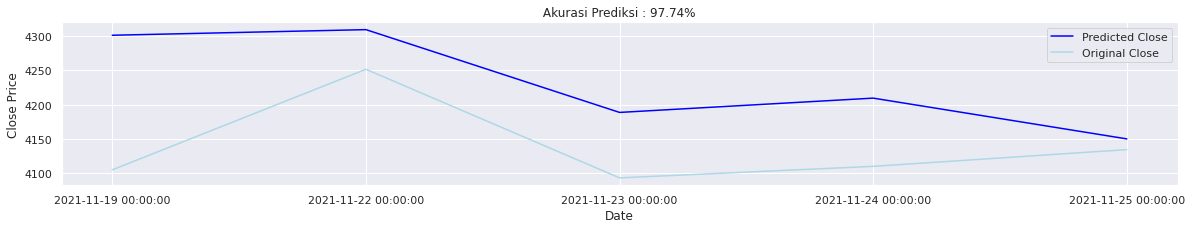

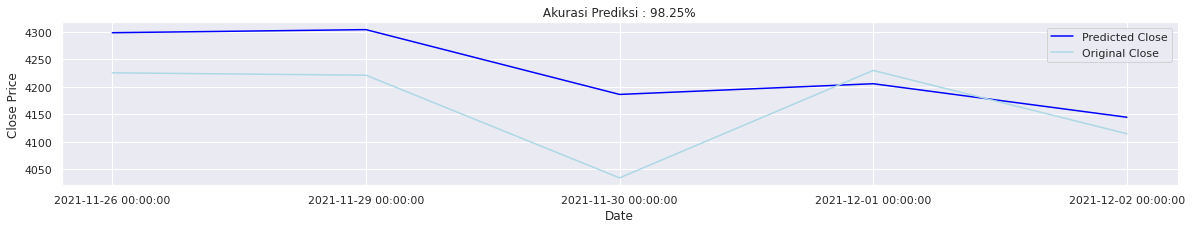

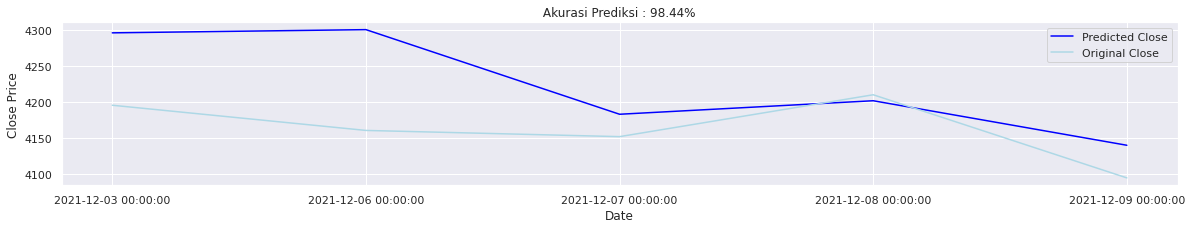

In [ ]:
perbandingan_prediksi(data, y_test, y_pred_lstm2)

---

### Visualisasi perbandingan dari model ketiga (BiLSTM)

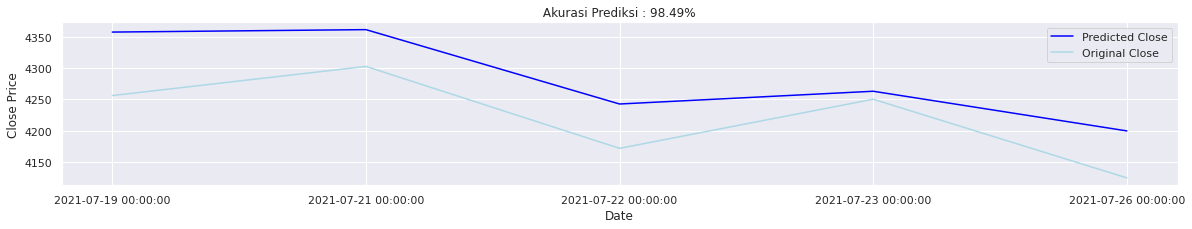

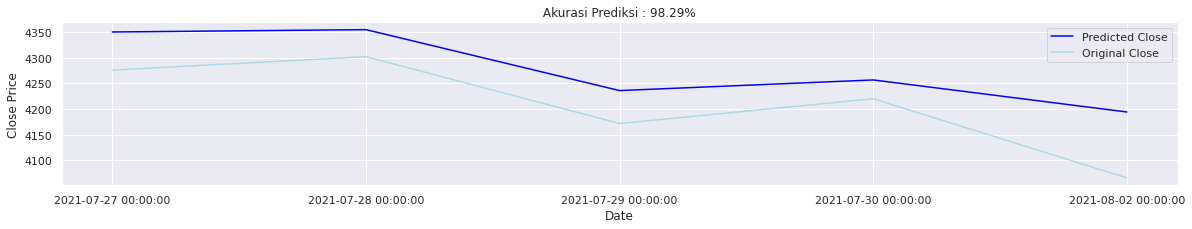

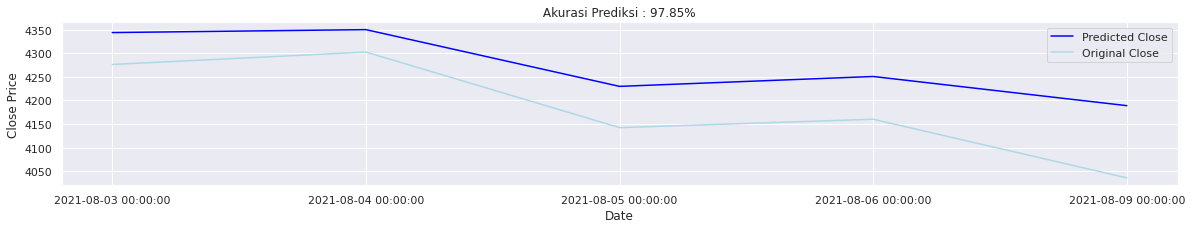

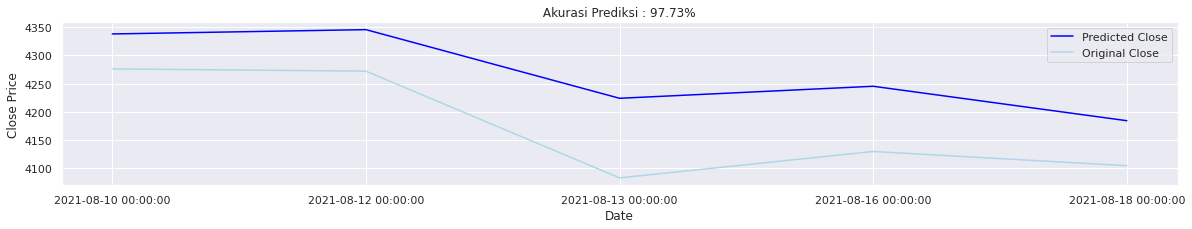

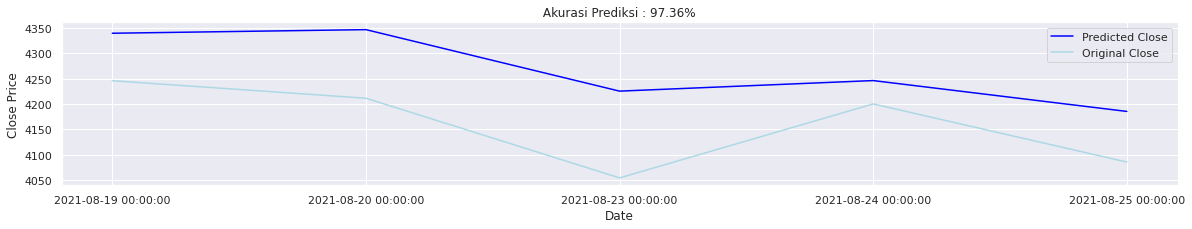

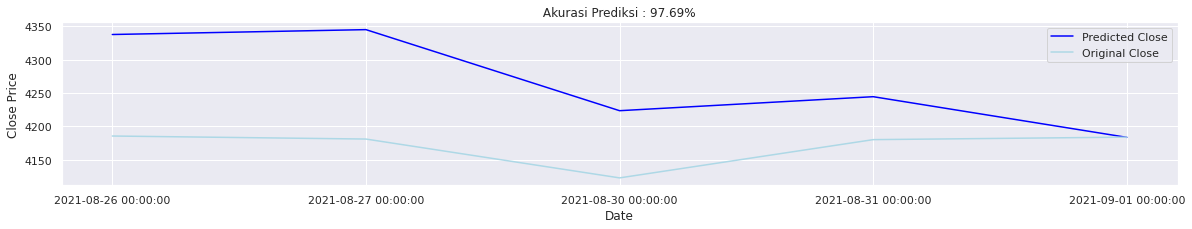

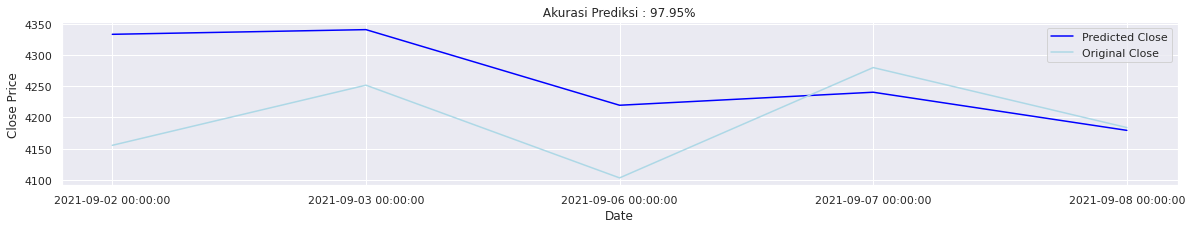

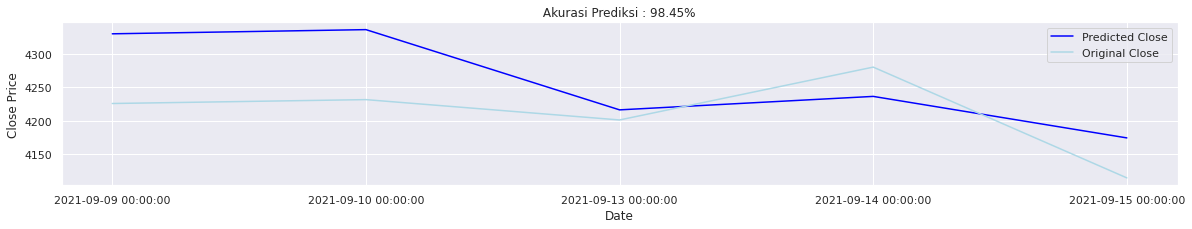

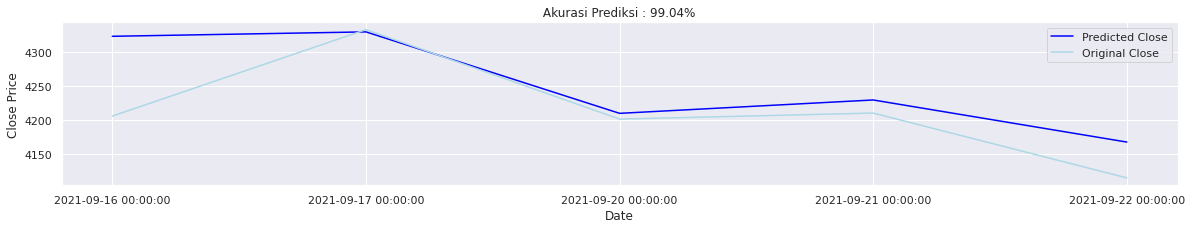

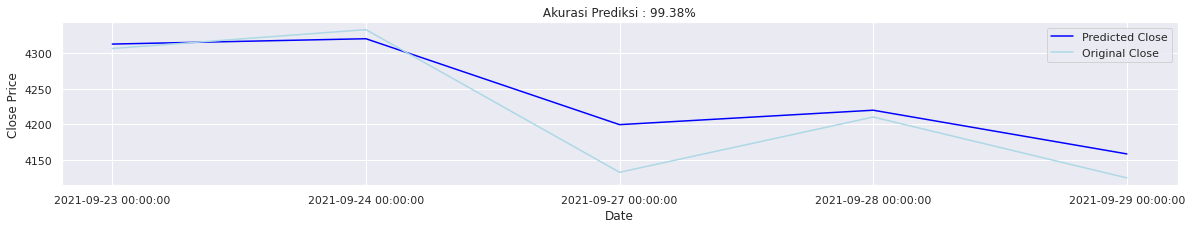

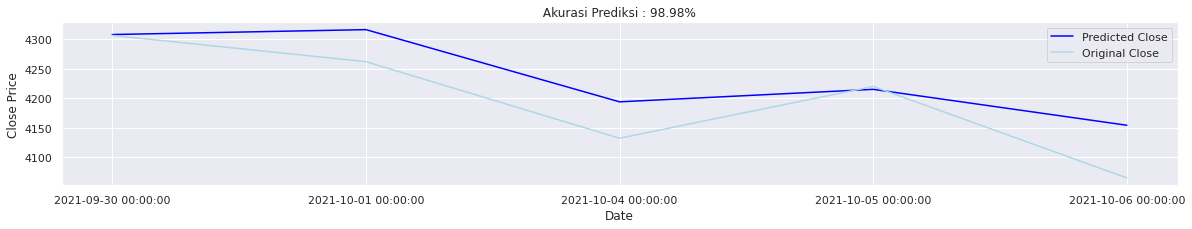

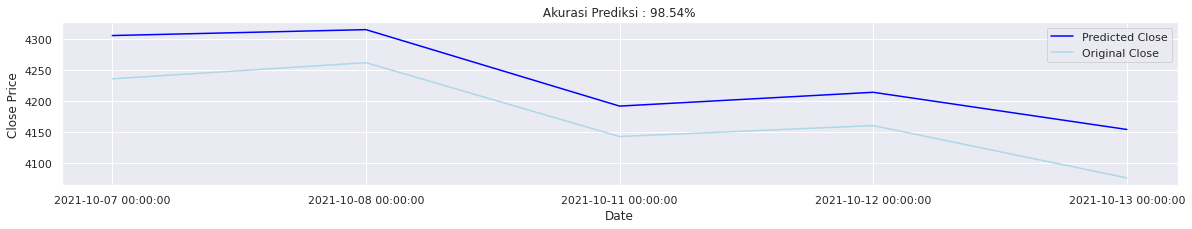

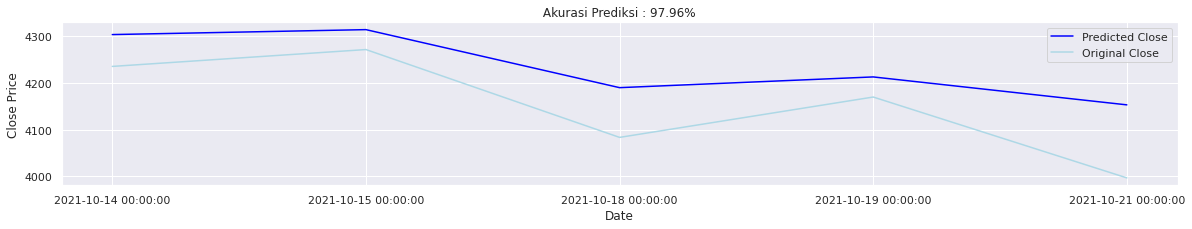

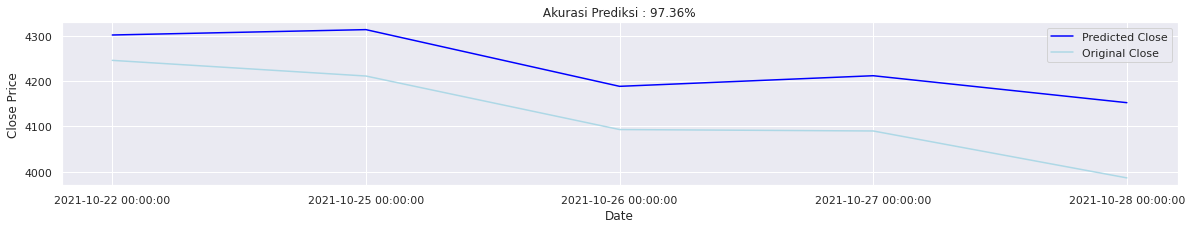

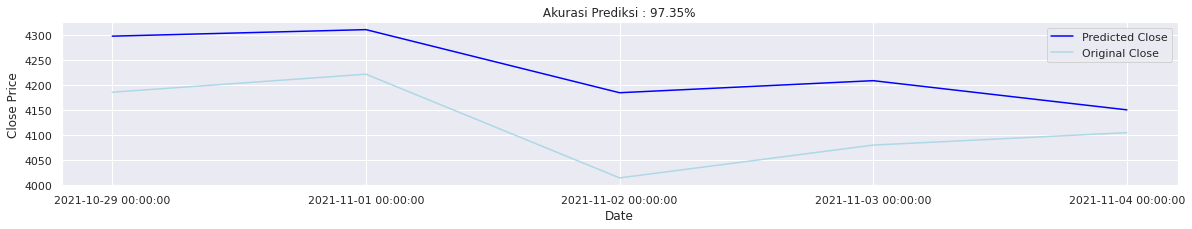

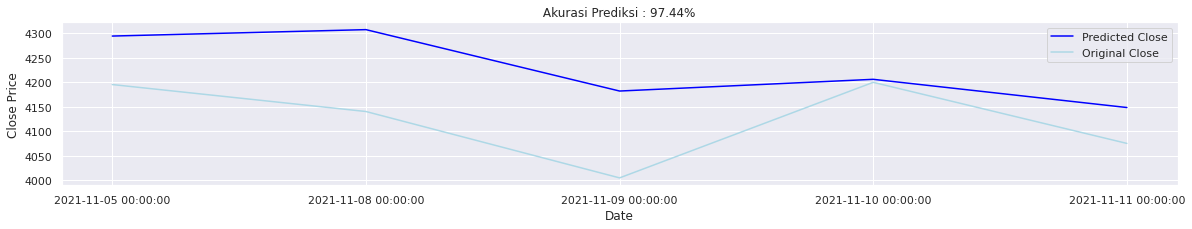

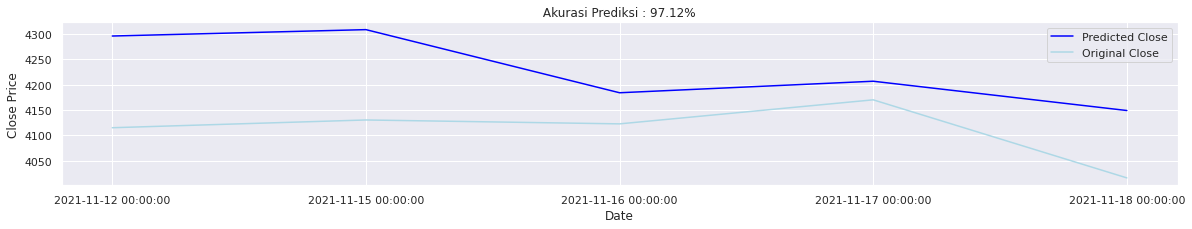

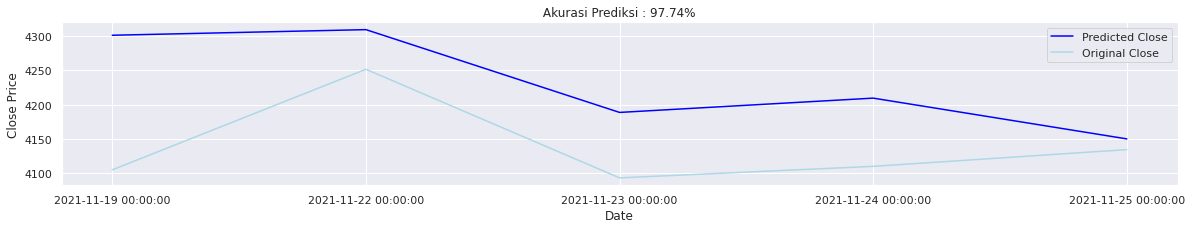

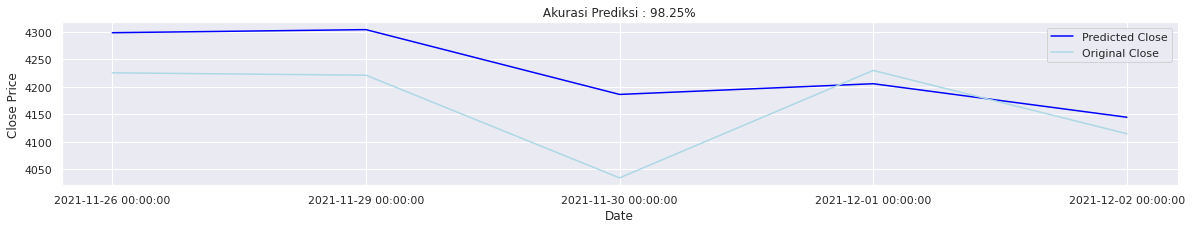

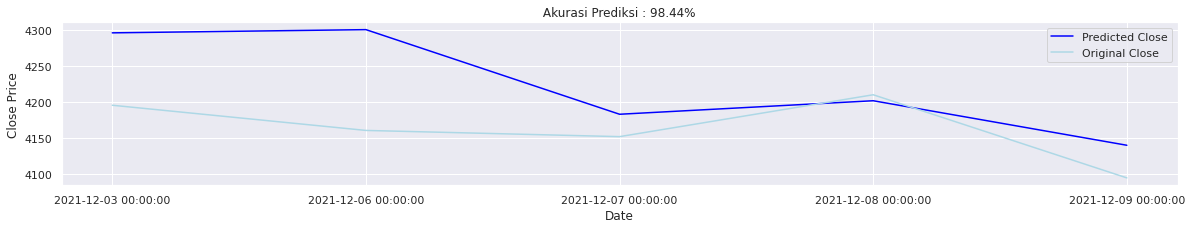

In [ ]:
perbandingan_prediksi(data, y_test, y_pred_lstm2)